[K-Means] k=5, init=random, iters=10, final SSE=1527.540


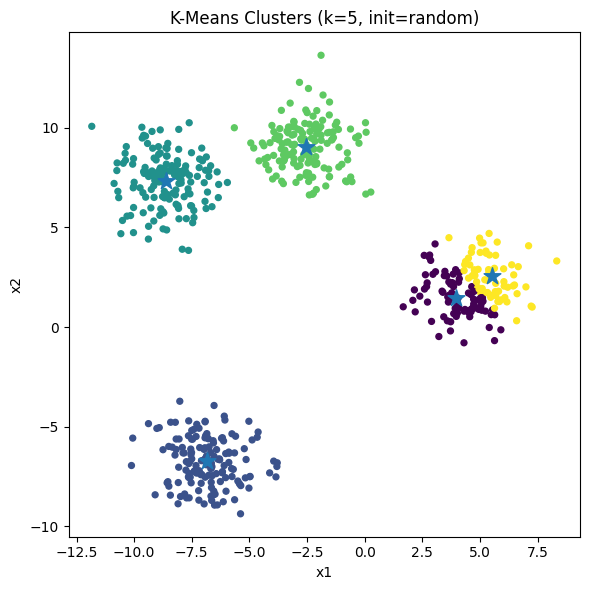

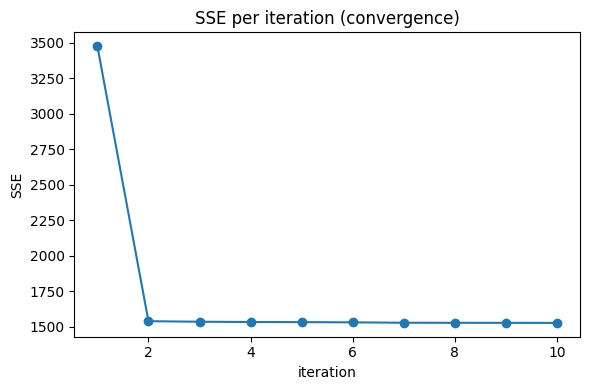

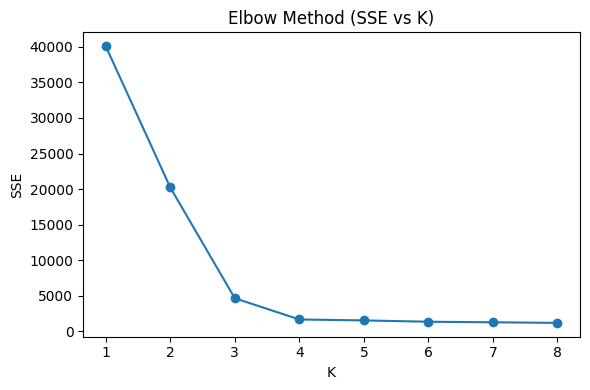

In [3]:

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 0) 데이터 준비: blobs / moons (moons는 KMeans에 어려운 케이스)
# -----------------------------
try:
    from sklearn.datasets import make_blobs, make_moons
    HAVE_SK = True
except:
    HAVE_SK = False

DATASET = 'blobs'   # 'blobs' or 'moons'
N_SAMPLES = 600
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

if HAVE_SK and DATASET == 'moons':
    X, _ = make_moons(n_samples=N_SAMPLES, noise=0.2, random_state=RANDOM_STATE)
elif HAVE_SK and DATASET == 'blobs':
    X, _ = make_blobs(n_samples=N_SAMPLES, centers=4, cluster_std=1.2, random_state=RANDOM_STATE)
else:
    # sklearn이 없으면 임의 2D 클러스터 생성
    c1 = np.random.randn(N_SAMPLES//3, 2) + np.array([0,0])
    c2 = np.random.randn(N_SAMPLES//3, 2) + np.array([6,5])
    c3 = np.random.randn(N_SAMPLES - 2*(N_SAMPLES//3), 2) + np.array([-6,4])
    X = np.vstack([c1, c2, c3])

# -----------------------------
# 1) 유틸 함수
# -----------------------------
def euclidean_sq(a, b):
    # a: (n,d), b: (m,d) -> (n,m) squared distance
    a2 = np.sum(a*a, axis=1, keepdims=True)
    b2 = np.sum(b*b, axis=1, keepdims=True).T
    return np.maximum(a2 + b2 - 2*a@b.T, 0.0)

def sse(X, centers, labels):
    # Sum of squared distances within clusters
    return np.sum((X - centers[labels])**2)

def init_random(X, k, rng):
    idx = rng.choice(len(X), size=k, replace=False)
    return X[idx].copy()

def init_kmeanspp(X, k, rng):
    # k-means++ 초기화
    n = len(X)
    centers = np.empty((k, X.shape[1]), dtype=float)
    # 첫 중심
    i0 = rng.integers(0, n)
    centers[0] = X[i0]
    # 이후 중심들
    d2 = euclidean_sq(X, centers[0:1]).ravel()  # 각 점과 가장 가까운 선택된 중심까지의 거리제곱
    for j in range(1, k):
        probs = d2 / d2.sum()
        idx = rng.choice(n, p=probs)
        centers[j] = X[idx]
        d2 = np.minimum(d2, euclidean_sq(X, centers[j:j+1]).ravel())
    return centers

# -----------------------------
# 2) K-Means 본체
# -----------------------------
def kmeans(X, k=4, max_iter=100, tol=1e-4, init='kmeans++', random_state=42):
    """
    X: (N, D)
    k: number of clusters
    tol: 중심 이동량 L2 합계가 tol 미만이면 수렴
    init: 'random' | 'kmeans++'
    return: centers, labels, history (list of SSE)
    """
    rng = np.random.default_rng(random_state)
    if init == 'random':
        centers = init_random(X, k, rng)
    elif init == 'kmeans++':
        centers = init_kmeanspp(X, k, rng)
    else:
        raise ValueError("init must be 'random' or 'kmeans++'")

    history = []
    for it in range(max_iter):
        # 할당 (Assignment)
        dist2 = euclidean_sq(X, centers)           # (N, k)
        labels = np.argmin(dist2, axis=1)          # (N,)

        # SSE 기록
        history.append(float(np.sum(np.min(dist2, axis=1))))

        # 갱신 (Update)
        new_centers = centers.copy()
        for j in range(k):
            mask = (labels == j)
            if np.any(mask):
                new_centers[j] = X[mask].mean(axis=0)
            # 비어있는 군집 방지용: 비면 가장 큰 SSE 기여점으로 재배치
            else:
                idx = np.argmax(np.min(euclidean_sq(X, new_centers), axis=1))
                new_centers[j] = X[idx]

        # 수렴 체크
        shift = np.linalg.norm(new_centers - centers)
        centers = new_centers
        if shift < tol:
            break

    return centers, labels, history

# -----------------------------
# 3) 실행 파라미터 & 학습
# -----------------------------
K = 5               # 군집 수
INIT = 'random'   # 'random' or 'kmeans++'
MAX_ITER = 200
TOL = 1e-4

centers, labels, hist = kmeans(X, k=K, max_iter=MAX_ITER, tol=TOL, init=INIT, random_state=RANDOM_STATE)
final_sse = hist[-1]

print(f"[K-Means] k={K}, init={INIT}, iters={len(hist)}, final SSE={final_sse:.3f}")

# -----------------------------
# 4) 시각화 1: 최종 클러스터 + 중심
# -----------------------------
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=labels, s=18)
plt.scatter(centers[:,0], centers[:,1], s=160, marker='*')
plt.title(f"K-Means Clusters (k={K}, init={INIT})")
plt.xlabel("x1"); plt.ylabel("x2")
plt.tight_layout()
plt.show()

# -----------------------------
# 5) 시각화 2: SSE 수렴 곡선
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(range(1, len(hist)+1), hist, marker='o')
plt.title("SSE per iteration (convergence)")
plt.xlabel("iteration")
plt.ylabel("SSE")
plt.tight_layout()
plt.show()

# -----------------------------
# 6) (옵션) Elbow Method: K 선택 도움
# -----------------------------
RUN_ELBOW = True
if RUN_ELBOW:
    ks = list(range(1, 9))
    elbow = []
    for k in ks:
        c, lb, h = kmeans(X, k=k, max_iter=MAX_ITER, tol=TOL, init=INIT, random_state=RANDOM_STATE)
        elbow.append(h[-1])
    plt.figure(figsize=(6,4))
    plt.plot(ks, elbow, marker='o')
    plt.title("Elbow Method (SSE vs K)")
    plt.xlabel("K")
    plt.ylabel("SSE")
    plt.xticks(ks)
    plt.tight_layout()
    plt.show()
